# Fashion-MNIST: Training and Testing on a Clean Dataset & Adversarial Analysis

## Imports and Fashion-MNIST loading

In [1]:
# For loading model sanely
import os.path

# Sys is used to add proper paths
import sys

import torch
import torch.nn as nn
from tqdm.notebook import tnrange, tqdm

# This here actually adds the path
sys.path.append("../")

import models.lenet as lenet

# For printing outcomes
import utils.printing as printing

In [2]:
# Define the `device` PyTorch will be running on, please hope it is CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Notebook will use PyTorch Device: " + device.upper())

Notebook will use PyTorch Device: CUDA


## Training, Validation and Testing

In [3]:
# Get the data loaders (assume we do no validation)
import utils.dataloaders as dataloaders

DATA_ROOT = "../datasets/"

trainSetLoader, _, testSetLoader = dataloaders.get_Fashion_MNIST_data_loaders(
    DATA_ROOT,
    trainSetSize=50000,
    validationSetSize=0,
    batchSize=64,
)

In [4]:
# This method creates a new model and also trains it
def get_trained_model(load_if_available=False):
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # If a trained model already exists, give up the training part
    if load_if_available and os.path.isfile("../fashion_mnist_model"):
        print("Found already trained model")

        model = torch.load("../fashion_mnist_model")

        # Return the loaded model
        return model

    print("Training the model...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Clean the gradients
            optimizer.zero_grad()

            # Predict
            logits = model(images)

            # Calculate loss
            loss = loss_function(logits, labels)

            # Gradient descent
            loss.backward()
            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

## Putting it all together (the 'main')

In [5]:
model = get_trained_model(load_if_available=True)

# From now on we simply test the model
model.eval()

# Test the loaded model
import utils.clean_test as clean_test

clean_test.test_trained_model(model, testSetLoader)

Found already trained model
Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 91.58%


In [6]:
# Save the model
torch.save(model, "../fashion_mnist_model")

## Attacks and Their Results

In [7]:
# A possible attacks array (for nice printing):
import utils.attacking as attacking

attacks = {}

### FGSM (Fast Sign Gradient Method) https://arxiv.org/abs/1412.6572

The formula that is used for producing the adversarial example in this case is:

$x' = x + \epsilon * sign(\nabla_{x}J(\theta, x, y))$, where J is the loss function used.

In [8]:
import attacks.fgsm as fgsm

attacks["FGSM"] = fgsm.fgsm_attack

In [9]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

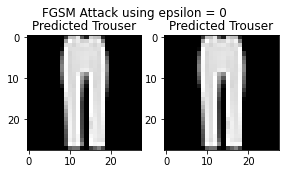

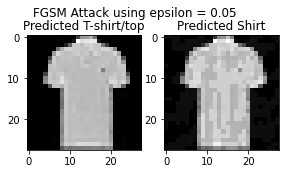

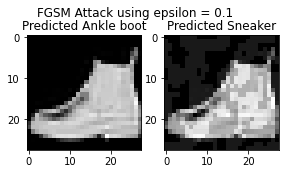

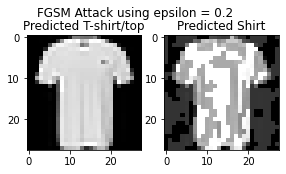

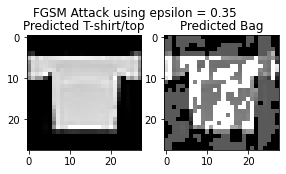

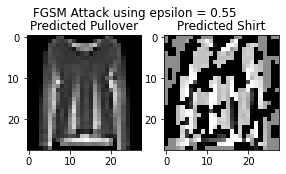

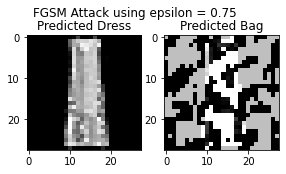

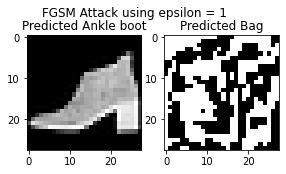

In [10]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

In [11]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 91.58%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 40.53%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.68%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 3.11%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.62%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.65%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 1.32%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 1.74%




### I-FGSM / BIM (Iterative FGSM / Basic Iterative Method) https://arxiv.org/abs/1607.02533

The formula that is used for producing the adversarial example in this case is:

$x'_{0} = x$
$x'_{k + 1} = Clip_{x, \epsilon} \{x'_{k} + \alpha * sign(\nabla_{x}J(\theta, x'_{k}, y)\}$, where J is the loss function used. Note that in the paper proposing this method, $\alpha = 1$ is used, so pixels are changed by 1 in each iteration.

The formula for the clip function is also given in the paper.

In [12]:
import attacks.ifgsm as ifgsm

attacks["I-FGSM"] = ifgsm.ifgsm_attack

In [13]:
# Several values for epsilon. It's interesting to see how clamping affects results
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55]

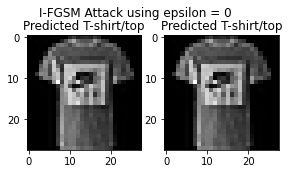

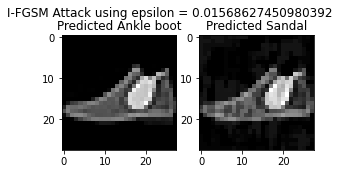

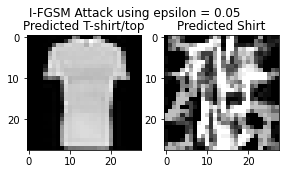

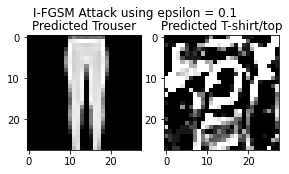

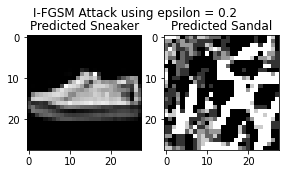

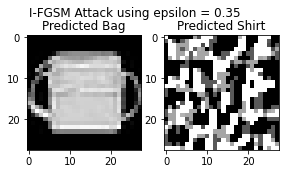

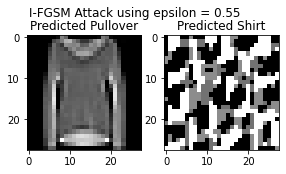

In [14]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "I-FGSM",
        attacks["I-FGSM"],
        epsilon=epsilon,
        alpha=1,
        iterations=0,
    )

In [69]:
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "I-FGSM",
        attacks["I-FGSM"],
        epsilon=epsilon,
        alpha=1,
        iterations=3,
    )

Testing the model under I-FGSM Attack using epsilon = 0, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 91.58%


Testing the model under I-FGSM Attack using epsilon = 0.01568627450980392, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 37.86%


Testing the model under I-FGSM Attack using epsilon = 0.05, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.63%


Testing the model under I-FGSM Attack using epsilon = 0.1, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.2, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.35, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.55, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.75, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 1, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.05%




### PGD (Projected Gradient Descent) https://arxiv.org/pdf/1706.06083.pdf

The formula that is used for producing the adversarial example in this case is:

$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$\n
where S is a set of allowed perturbations. Note that this is basically BIM with random initialisation. 

We use the $L_{\infty}$ norm here, i.e. we use clamping. 

In [16]:
import attacks.pgd as pgd

In [17]:
attacks["PGD"] = pgd.pgd_attack

In [18]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

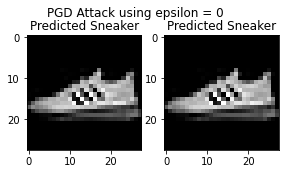

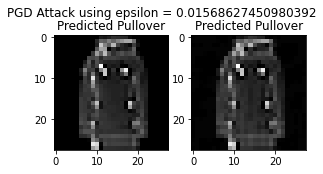

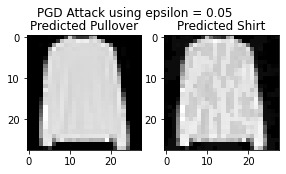

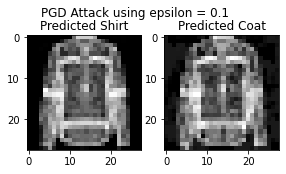

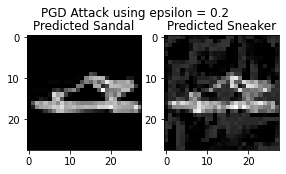

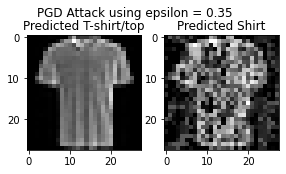

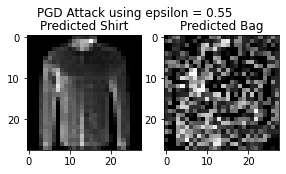

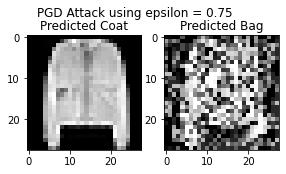

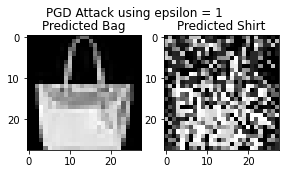

In [19]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

In [20]:
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 91.58%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 73.36%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 29.97%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 3.29%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.06%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




## From here, use existing libraries to simplify usageimport torchattacks


In [21]:
import torchattacks

### DeepFool https://arxiv.org/pdf/1511.04599.pdf

The formula here is complex, so I recommend for the interested reader to go the above link to read the full paper.

In [22]:
deepfool_attack = torchattacks.DeepFool(model)

attacks["DeepFool"] = deepfool_attack

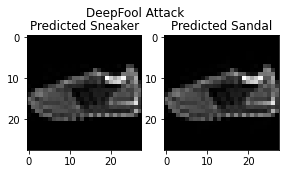

In [23]:
printing.print_attack(
    model, testSetLoader, "DeepFool", attacks["DeepFool"], library=True
)

In [24]:
attacking.attack_model(
    model,
    testSetLoader,
    "DeepFool",
    attacks["DeepFool"],
    library=True,
)

Testing the model under DeepFool Attack...


DeepFool Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.34%




### CW-$L_{2}$ (Carlini & Wagner using $L_{2}$ norm) https://arxiv.org/pdf/1608.04644.pdf

The formula here is complex, so I recommend for the interested reader to go the above link to read the full paper.

In [25]:
cw_attack = torchattacks.CW(model, c=25)

attacks["CW"] = cw_attack

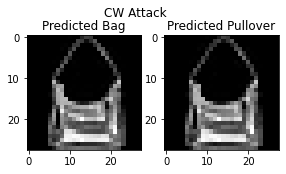

In [26]:
printing.print_attack(model, testSetLoader, "CW", attacks["CW"], library=True)

In [27]:
attacking.attack_model(
    model,
    testSetLoader,
    "CW",
    attacks["CW"],
    library=True,
)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




## Adversarial Training

In [28]:
# Adversarial examples should be typically generated when model parameters are not
# changing i.e. model parameters are frozen. This step may not be required for very
# simple linear models, but is a must for models using components such as dropout
# or batch normalization.
def get_adversarially_trained_model(attack, **kwargs):
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Get the attack
    attack_function = attacks[attack]

    print("Training the model using adversarial examples...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Adversarial Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Run the attack
            model.eval()
            perturbed_images = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
            model.train()

            # Predict and optimise
            optimizer.zero_grad()

            logits = model(perturbed_images)
            loss = loss_function(logits, labels)

            # Gradient descent
            loss.backward()
            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

### FGSM Adversarial Training

In [29]:
fgsm_model = get_adversarially_trained_model("FGSM", epsilon=0.2)

fgsm_model.eval()

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [30]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [31]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        fgsm_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 62.62%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 62.69%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 79.48%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 92.45%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 76.35%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 17.58%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 16.18%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 16.37%




In [32]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [33]:
for epsilon in epsilons:
    attacking.attack_model(
        fgsm_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 62.62%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 46.95%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 23.71%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.89%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 8.43%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 5.62%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 2.38%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.72%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.3%




In [34]:
clean_test.test_trained_model(fgsm_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 62.62%


### PGD Adversarial Training

In [35]:
pgd_model = get_adversarially_trained_model(
    "PGD", epsilon=0.6, alpha=(2 / 255), iterations=7
)

pgd_model.eval()

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [36]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [37]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        pgd_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 77.74%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 66.4%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 55.97%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 38.08%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 24.2%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 24.3%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 8.58%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 9.65%




In [38]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [39]:
for epsilon in epsilons:
    attacking.attack_model(
        pgd_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 77.74%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 74.17%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 68.12%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 67.1%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 68.94%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 72.69%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 75.97%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 35.33%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 8.76%




In [40]:
clean_test.test_trained_model(pgd_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 77.74%


## Jacobian Regularization

In [41]:
import jacobian


def get_jacobian_reg_trained_model():
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Jacobian regularization
    jacobian_reg = jacobian.JacobianReg()
    jacobian_reg_lambda = 0.01

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    print("Training the model using Jacobian Regularization...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Jacobian Regularization Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Require gradients for Jacobian regularization
            images.requires_grad = True

            # Predict and optimise
            optimizer.zero_grad()

            # Predict
            logits = model(images)

            # Calculate loss
            loss = loss_function(logits, labels)

            # Introduce Jacobian regularization
            jacobian_reg_loss = jacobian_reg(images, logits)

            # Total loss
            loss = loss + jacobian_reg_lambda * jacobian_reg_loss

            # Gradient descent
            loss.backward()
            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

In [42]:
jacobian_reg_model = get_jacobian_reg_trained_model()

# From now on we simply test the model
jacobian_reg_model.eval()

Training the model using Jacobian Regularization...


Jacobian Regularization Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

/home/calin/.local/lib/python3.8/site-packages/jacobian/jacobian.py:70: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  v=torch.addcdiv(arxilirary_zero, 1.0, v, vnorm)


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [43]:
clean_test.test_trained_model(jacobian_reg_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 89.35%


In [44]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [45]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        jacobian_reg_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 89.35%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 70.19%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 48.45%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 17.85%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 2.85%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 3.27%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 4.81%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 6.28%




In [46]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [47]:
for epsilon in epsilons:
    attacking.attack_model(
        jacobian_reg_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 89.35%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 84.08%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 71.74%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 64.36%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 57.03%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 47.51%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 26.99%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 11.41%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 3.68%




## Interpolated Adversarial Training (with Jacobian Regularization)

In [48]:
from jacobian import JacobianReg

import defenses.iat as iat


def get_interpolated_adversarially_trained_model(attack, **kwargs):
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Jacobian regularization
    jacobian_reg = JacobianReg()
    jacobian_reg_lambda = 0.01

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Get the attack
    attack_function = attacks[attack]

    print("Training the model using adversarial examples...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Adversarial Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Use manifold mixup to modify the data
            (
                benign_mix_images,
                benign_mix_labels_a,
                benign_mix_labels_b,
                benign_mix_lamda,
            ) = iat.mix_inputs(1, images, labels)

            # Run the adversarial attack
            model.eval()
            perturbed_images = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
            model.train()

            # Use manifold mixup on the adversarial data
            (
                adversarial_mix_images,
                adversarial_mix_labels_a,
                adversarial_mix_labels_b,
                adversarial_mix_lamda,
            ) = iat.mix_inputs(1, perturbed_images, labels)

            # Predictions are regularization
            benign_mix_images.requires_grad = True
            adversarial_mix_images.requires_grad = True

            optimizer.zero_grad()

            # Predict and calculate benign loss
            benign_logits = model(benign_mix_images)

            benign_loss = iat.mixup_loss_function(
                loss_function,
                benign_mix_lamda,
                benign_logits,
                benign_mix_labels_a,
                benign_mix_labels_b,
            )

            # Introduce Jacobian regularization
            jacobian_reg_loss = jacobian_reg(benign_mix_images, benign_logits)

            # Total benign loss
            benign_loss = benign_loss + jacobian_reg_lambda * jacobian_reg_loss

            # Predict and calculate adversarial loss
            adversarial_logits = model(adversarial_mix_images)
            adversarial_loss = iat.mixup_loss_function(
                loss_function,
                adversarial_mix_lamda,
                adversarial_logits,
                adversarial_mix_labels_a,
                adversarial_mix_labels_b,
            )

            # Introduce Jacobian regularization
            jacobian_reg_loss = jacobian_reg(adversarial_mix_images, adversarial_logits)

            # Total adversarial loss
            adversarial_loss = (
                adversarial_loss + jacobian_reg_lambda * jacobian_reg_loss
            )

            # Take average of the two losses
            loss = (benign_loss + adversarial_loss) / 2

            # Gradient descent
            loss.backward()
            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

In [49]:
iat_pgd_model = get_interpolated_adversarially_trained_model(
    "PGD", epsilon=0.6, alpha=(2 / 255), iterations=7
)

iat_pgd_model.eval()

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [50]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [51]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        iat_pgd_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 87.26%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 71.82%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 56.7%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 38.06%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 21.47%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 1.64%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 1.0%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 2.93%




In [52]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [53]:
for epsilon in epsilons:
    attacking.attack_model(
        iat_pgd_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 87.26%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 82.5%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 73.17%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 69.22%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 67.54%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 68.24%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 67.56%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 62.62%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 37.17%




In [54]:
clean_test.test_trained_model(iat_pgd_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 87.26%


## Adversarial Logit Pairing (https://arxiv.org/pdf/1803.06373.pdf)

In [55]:
def get_alp_trained_model(attack, **kwargs):
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # ALP factor
    alp_loss_function = nn.MSELoss()
    alp_lamda = 0.2

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Get the attack
    attack_function = attacks[attack]

    print("Training the model using adversarial examples...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Adversarial Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Run the attack
            model.eval()
            perturbed_images = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
            model.train()

            # Predict and optimise
            optimizer.zero_grad()

            logits = model(images)
            loss = loss_function(logits, labels) + alp_lamda * alp_loss_function(
                model(images), model(perturbed_images)
            )

            # Gradient descent
            loss.backward()

            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

In [56]:
alp_model = get_alp_trained_model("PGD", epsilon=0.6, alpha=(2 / 255), iterations=7)

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


In [57]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [58]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        alp_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 90.93%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 63.87%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 48.04%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 35.16%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 21.52%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 4.51%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 3.63%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 5.96%




In [59]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [60]:
for epsilon in epsilons:
    attacking.attack_model(
        alp_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 90.93%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 82.53%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 64.07%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 58.18%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 57.37%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 61.98%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 65.85%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 59.87%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 23.45%




In [61]:
clean_test.test_trained_model(alp_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 90.93%


## Combined Defenses

In [62]:
def get_alp_interpolated_adversarially_trained_model(attack, **kwargs):
    # ALP factor
    alp_loss_function = nn.MSELoss()
    alp_lamda = 0.2

    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Jacobian regularization
    jacobian_reg = JacobianReg()
    jacobian_reg_lambda = 0.01

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Get the attack
    attack_function = attacks[attack]

    print("Training the model using adversarial examples...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Adversarial Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Use manifold mixup to modify the data
            (
                benign_mix_images,
                benign_mix_labels_a,
                benign_mix_labels_b,
                benign_mix_lamda,
            ) = iat.mix_inputs(1, images, labels)

            # Run the adversarial attack
            model.eval()
            perturbed_images = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
            model.train()

            # Use manifold mixup on the adversarial data
            (
                adversarial_mix_images,
                adversarial_mix_labels_a,
                adversarial_mix_labels_b,
                adversarial_mix_lamda,
            ) = iat.mix_inputs(1, perturbed_images, labels)

            # Predictions are regularization
            benign_mix_images.requires_grad = True
            adversarial_mix_images.requires_grad = True

            optimizer.zero_grad()

            # Predict and calculate benign loss
            benign_logits = model(benign_mix_images)

            benign_loss = iat.mixup_loss_function(
                loss_function,
                benign_mix_lamda,
                benign_logits,
                benign_mix_labels_a,
                benign_mix_labels_b,
            )

            # Introduce Jacobian regularization
            jacobian_reg_loss = jacobian_reg(benign_mix_images, benign_logits)

            # Total benign loss
            benign_loss = benign_loss + jacobian_reg_lambda * jacobian_reg_loss

            # Predict and calculate adversarial loss
            adversarial_logits = model(adversarial_mix_images)
            adversarial_loss = iat.mixup_loss_function(
                loss_function,
                adversarial_mix_lamda,
                adversarial_logits,
                adversarial_mix_labels_a,
                adversarial_mix_labels_b,
            )

            # Introduce Jacobian regularization
            jacobian_reg_loss = jacobian_reg(adversarial_mix_images, adversarial_logits)

            # Total adversarial loss
            adversarial_loss = (
                adversarial_loss + jacobian_reg_lambda * jacobian_reg_loss
            ) + alp_lamda * alp_loss_function(
                model(benign_mix_images), model(adversarial_mix_images)
            )

            # Take average of the two losses
            loss = (benign_loss + adversarial_loss) / 2

            # Gradient descent
            loss.backward()
            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

In [63]:
alp_iat_model = get_alp_interpolated_adversarially_trained_model(
    "PGD", epsilon=0.6, alpha=(2 / 255), iterations=7
)

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


In [64]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [65]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        alp_iat_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 87.27%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 72.63%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 58.75%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 40.98%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 19.85%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 3.19%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.41%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.65%




In [66]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [67]:
for epsilon in epsilons:
    attacking.attack_model(
        alp_iat_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 87.27%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 82.93%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 74.01%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 70.11%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 67.99%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 68.25%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 67.35%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 61.57%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 39.46%




In [68]:
clean_test.test_trained_model(alp_iat_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 87.27%
